# Tissue Classification using Texture Features
In this lab we will explore the use of texture in images and traditional machine learning approaches such as clustering. The dataset we will be using is available here: http://dx.doi.org/10.5281/zenodo.53169. 

![alt text](https://www.researchgate.net/profile/Jakob_Kather/publication/303998214/figure/fig7/AS:391073710002224@1470250646407/Representative-images-from-our-dataset-Here-the-first-10-images-of-every-tissue-class.png)

The above figure shows the 8 different classes of tissue we will be trying to classify. 

In [0]:
# Imports
from __future__ import print_function
import os
import numpy as np
from sklearn.utils import shuffle
import matplotlib.pylab as plt
from skimage import color
from skimage import feature

In [43]:
! git clone https://github.com/BeaverWorksMedlytics/Week3_public.git
# Build the path to the data folder. No need to change directories
# There are a total of 6 files you will have to load
data_dir = os.path.join( os.getcwd(), 'Week3_public', 'data', 'crc')

fatal: destination path 'Week3_public' already exists and is not an empty directory.



## Step 1
* Load the data
* Split data into training and testing subsets

In [52]:
# Load data 
y = np.load(os.path.join(data_dir, 'rgb01.npz'))
labels = y['labels']
data = y['rgb_data']
data = data[:,:,:,0]
label_str = y['label_str']
label_str = label_str.tolist() # this is to convert label_str back to a dictionary
y = []

print(data.shape)
for ii in range(2,6):
    filename = os.path.join(data_dir, 'rgb0' + str(ii) + '.npz')
    print('loading ', filename)
    y = np.load(filename)
    labels = np.append(labels, y['labels'], axis=0)
    data = np.append(data, y['rgb_data'][:,:,:,0], axis=0)
    print(data.shape)
    y = []

data = data.astype('float')

print( data.shape )
print( labels.shape )

num_images, nrows, ncols = data.shape

(1000, 150, 150)
loading  /content/Week3_public/data/crc/rgb02.npz
(2000, 150, 150)
loading  /content/Week3_public/data/crc/rgb03.npz
(3000, 150, 150)
loading  /content/Week3_public/data/crc/rgb04.npz
(4000, 150, 150)
loading  /content/Week3_public/data/crc/rgb05.npz
(5000, 150, 150)
(5000, 150, 150)
(5000,)


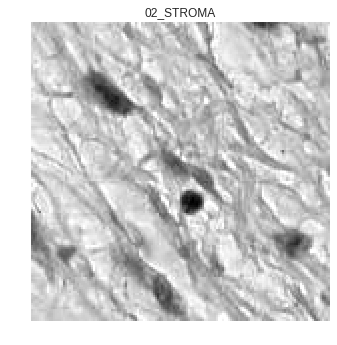

In [45]:
# show sample data
ii = 2
plt.figure()
plt.imshow(data[ii,::])
plt.title(label_str[labels[ii]])
plt.gray()
plt.axis('off')
plt.show()

## Step 2
Next, we will generate features we will be using for classification. 

**First Approach :**
* Try using the raw images as input features in a k-means clustering algorithm and see how well it performs
* Colorspace transformation: Convert the RGB image into the LAB colorspace and use the *a* and *b* channels as features only. How well does this work ? 


In [56]:
# Try using raw data as the features
# First reshape the data into the correct format expected by KMeans() function

#data = skimage.color.rgb2lab(data)
data = data[0:num_images:2]
labels = labels[0:num_images:2]
num_images, nrows, ncols = data.shape
#data = color.rgb2lab(data)
data = data.reshape((num_images, nrows,ncols))
#print(data.shape)

data = data.astype('uint8')

dissimilarity = []
correlation = []

for img in data:
  print(img.shape)
  glcm = feature.greycomatrix(img, [1], [0, np.pi/4, np.pi/2, 3*np.pi/4])
  dissimilarity.append(feature.greycoprops(glcm, 'dissimilarity')[0, 0])
  correlation.append(feature.greycoprops(glcm, 'correlation')[0, 0])

  

ValueError: ignored

## Step 3
Use k-means clustering to classify the images into 8 classes.

In [24]:
from sklearn.cluster import KMeans

estimator = KMeans(n_clusters=8, max_iter=10)
clusters = estimator.fit_predict(data.astype('float'))
print('done')

done


We need to map the labels corresponding to the tissue types to the class IDs assigned by k-means clustering. Here, we use the ```mode1``` function to map the assigned class IDs to the actual class labels.

In [25]:
from scipy.stats import mode
pred_labels = np.zeros_like(clusters)
mask = (clusters == 0)

for i in range(8):
    mask = (clusters == i)
    pred_labels[mask] = mode(labels[mask])[0]

ii = 10
plt.figure(figsize=(18, 16), dpi=80)
for ii in range(8,16):
    plt.subplot(2,4,ii-8+1)
    plt.imshow(data[ii].reshape((150, 150, 3)))
    plt.gray()
    plt.title('predicted:' + label_str[pred_labels[ii]] + '\n' +
              'expected:' + label_str[labels[ii]])
    plt.axis('off')

plt.show()


ValueError: ignored

## Step 4
Check the performance of the model

In [28]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

mat = confusion_matrix(labels, pred_labels)
acc = accuracy_score(labels, pred_labels)
print(acc)
print(mat)

0.5244
[[195  21  30   0  67   0   0   0]
 [  2 179  13  79  38   0   1   0]
 [168  14 119   0   5   7   0   0]
 [  3  21   1 163  18   0 106   0]
 [ 31  35   6  21 215   0   5   0]
 [  0   0   1   0   0 311   0   0]
 [  0  18   0 150  16   0 129   0]
 [  0   0   5   0   0 307   0   0]]


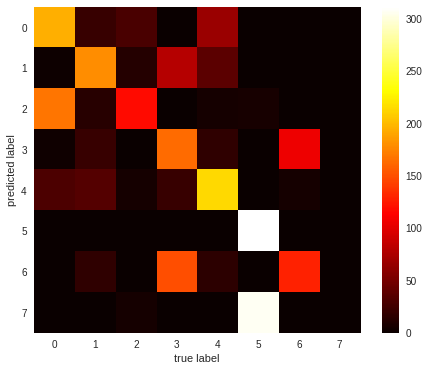

In [27]:
plt.figure(figsize=(8,6))
plt.imshow(mat, cmap='hot', interpolation='nearest')
plt.grid(False)
plt.colorbar()
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

## Assignment
Let's explore the use of different color and texture measures
* Use RGB images instead of grayscale images
* Histogram based features
* Colorspace conversion + histogram features
* Co-occurence matrix based texture measures
* Lobal binary patterns
* Perceptual features

Here we have lots of choices on how we can calculate various features and how we can combine them. 
* Try using first-order histogram features such the mean, standard deviation, moments (scipy.stats.moments) as features
    * These features can be calculated on each channel of the RGB image as well as on any other colorspace that you transform the image into. Suggestion : use the LAB colorspace also and see how well/poorly it performs
* Use the Gray Level Co-Occurence Matrix (GLCM) based features for texture (skimage.feature.greycomatrix and skimage.feature.greycoprops) 
* Use Local Binay Patterns (LBP) for texture (skimage.feature.local_binary_pattern)
* Try combinations of the above features 

##### What do you observe here ? Which method performs the best ?

